In [2]:
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

import tensorflow as tf

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

In [3]:
cifar = tf.keras.datasets.cifar10
# loading the data set
(X_train, y_train), (X_test, y_test) = cifar.load_data()


In [4]:
# image variables for sizing
img_size = 32
img_chan = 3
n_classes = 10

# Reshaping the training data 
X_train = np.reshape(X_train, [-1, img_size, img_size, img_chan])
X_train = X_train.astype(np.float32) / 255

# Reshaping the testing data
X_test = np.reshape(X_test, [-1, img_size, img_size, img_chan])
X_test = X_test.astype(np.float32) / 255

# converting the labels to categorical values
to_categorical = tf.keras.utils.to_categorical
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [5]:
tf.random.set_seed(0)
# Tensorflow Keras Model with 2 Convolution Layers and Max Pooling
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding = 'same', input_shape=(32,32,3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding = 'same', input_shape=(32,32,3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=5, batch_size=32, validation_data=(X_test, y_test))

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.4261 - loss: 1.5990 - val_accuracy: 0.6053 - val_loss: 1.1241
Epoch 2/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step - accuracy: 0.6350 - loss: 1.0304 - val_accuracy: 0.6410 - val_loss: 1.0189
Epoch 3/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.6993 - loss: 0.8678 - val_accuracy: 0.6525 - val_loss: 1.0042
Epoch 4/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 16s 10ms/step - accuracy: 0.7368 - loss: 0.7601 - val_accuracy: 0.6708 - val_loss: 0.9823
Epoch 5/5
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 17s 11ms/step - accuracy: 0.7695 - loss: 0.6679 - val_accuracy: 0.6827 - val_loss: 0.9646


In [6]:
# Creating images from test set

# List of class labels
class_labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

def create_img(i, test = True):
    '''
    Creates an png of the ith picture in the data set

    i: integer
        - index of the picture
    test: logical
        - if True then creates them from the test set
        - if False then creates them from the training set
    '''
    if test:
        # index of true label
        index_true = np.where(y_test[i] == 1)[0][0]

        # Predict the class probabilities
        single_image = X_test[i:i+1]  # Add batch dimension (1, 32, 32, 3)
        single_prediction = model.predict(single_image)
        # index of predicted label
        index_predicted = tf.argmax(single_prediction[0])

        plt.imshow(X_test[i])
        plt.title(f"Label: {class_labels[index_true]}, Predicted Class: {class_labels[index_predicted]}")
        plt.axis('off')  # Hide the axis

        plt.savefig(f'plot_test_img{i}.png')
    else:
        # index of true label
        index_true = np.where(y_train[i] == 1)[0][0]

        # Predict the class probabilities
        single_image = X_train[i:i+1]  # Add batch dimension (1, 32, 32, 3)
        single_prediction = model.predict(single_image)
        # index of predicted label
        index_predicted = tf.argmax(single_prediction[0])

        plt.imshow(X_train[i])
        plt.title(f"Label: {class_labels[index_true]}, Predicted Class: {class_labels[index_predicted]}")
        plt.axis('off')  # Hide the axis

        plt.savefig(f'plot_train_img{i}.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


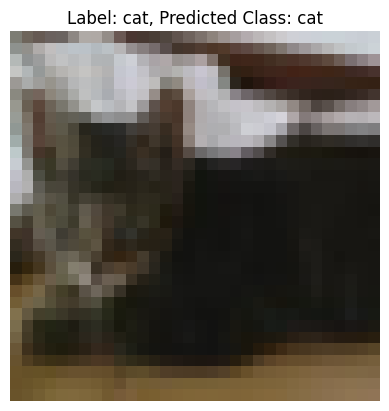

In [7]:
for i in range(10):
    create_img(i)
for i in range(10):
    create_img(i, test = False)

In [8]:
def fgsm_attack(image, label, model, epsilon):
    """
    Generates adversarial examples using FGSM.
    
    image: tf.Tensor
        Input image to perturb, shape (1, 32, 32, 3).
    label: tf.Tensor
        True label of the image, shape (1, 10).
    model: tf.keras.Model
        The trained model.
    epsilon: float
        The strength of the perturbation.
    """
    
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    label = tf.convert_to_tensor(label, dtype=tf.float32)
    
    # Ensure the image has a gradient
    with tf.GradientTape() as tape:
        tape.watch(image)  # Watch the input image
        prediction = model(image)  # Get model predictions
        loss = tf.keras.losses.categorical_crossentropy(label, prediction)  # Compute loss

    # Calculate gradients of loss w.r.t. the image
    gradient = tape.gradient(loss, image)
    signed_grad = tf.sign(gradient)  # Get sign of gradients

    # Generate the adversarial example
    adv_image = image + epsilon * signed_grad
    adv_image = tf.clip_by_value(adv_image, 0, 1)  # Keep the pixel values in [0, 1]
    return adv_image, signed_grad


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


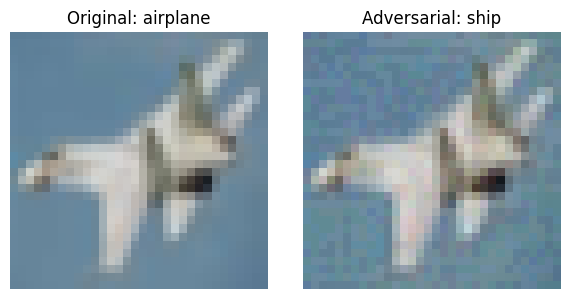

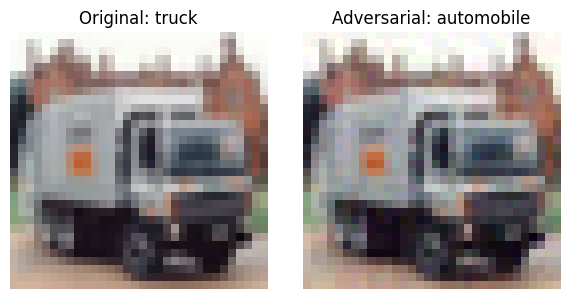

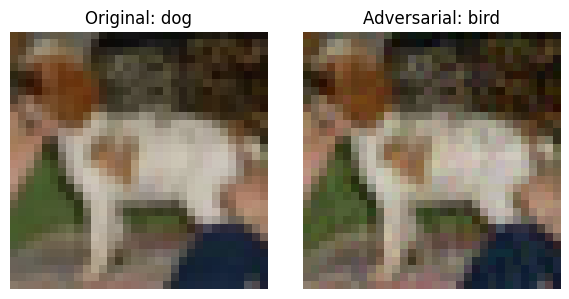

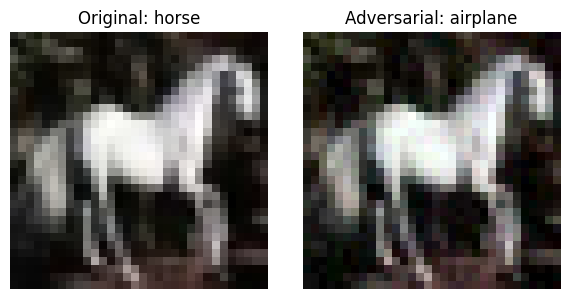

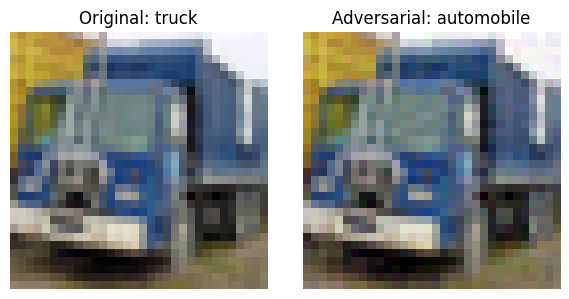

In [14]:
def test_fgsm_attack(num, epsilon):
    """
    Tests FGSM attack on a batch of images and visualizes the results.
    Saves result pngs in img folder
    
    epsilon: float
        Strength of the FGSM attack.
    """
    for i in range(num,num+5):  # Visualize 5 examples
        image = X_test[i:i+1]  # Select one image (add batch dimension)
        label = y_test[i:i+1]  # True label of the image

        # Generate adversarial example
        adv_image, signed_grad = fgsm_attack(image, label, model, epsilon)

        # Get predictions for both clean and adversarial images
        clean_pred = model.predict(image)
        adv_pred = model.predict(adv_image)

        clean_class = class_labels[np.argmax(clean_pred)]
        adv_class = class_labels[np.argmax(adv_pred)]

        # Plot the results
        plt.figure(figsize=(6, 3))

        # Original image
        plt.subplot(1, 2, 1)
        plt.imshow(image[0])
        plt.title(f"Original: {clean_class}")
        plt.axis('off')

        # Adversarial image
        plt.subplot(1, 2, 2)
        plt.imshow(adv_image[0])
        plt.title(f"Adversarial: {adv_class}")
        plt.axis('off')

        plt.tight_layout()
        # plt.show()
        plt.savefig(f'../img/fgmt_img{num + i}.png')
        

test_fgsm_attack(10, 0.02)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].


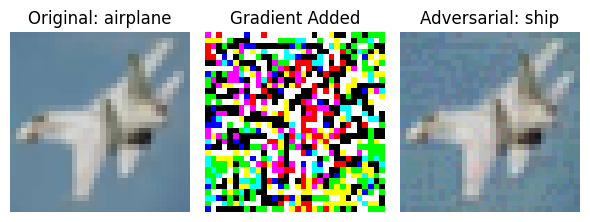

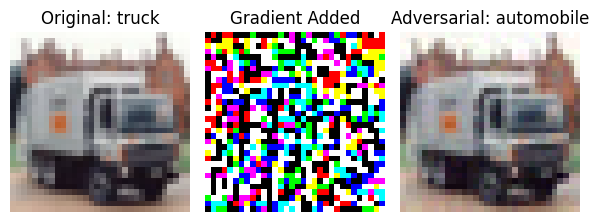

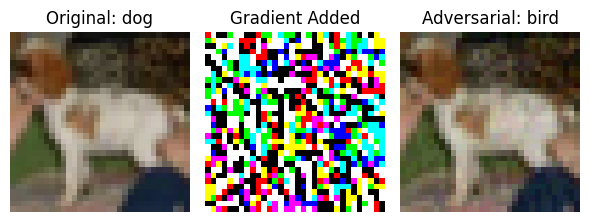

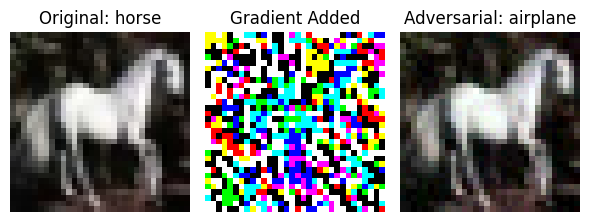

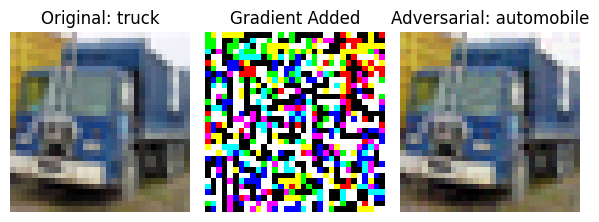

In [15]:
def test_fgsm_attack_w_grad(num, epsilon):
    """
    Tests FGSM attack on a batch of images and visualizes the results.
    Saves result pngs in img folder
    
    epsilon: float
        Strength of the FGSM attack.
    """
    for i in range(num,num+5):  # Visualize 5 examples
        image = X_test[i:i+1]  # Select one image (add batch dimension)
        label = y_test[i:i+1]  # True label of the image

        # Generate adversarial example
        adv_image, signed_grad = fgsm_attack(image, label, model, epsilon)

        # Get predictions for both clean and adversarial images
        clean_pred = model.predict(image)
        adv_pred = model.predict(adv_image)

        clean_class = class_labels[np.argmax(clean_pred)]
        adv_class = class_labels[np.argmax(adv_pred)]

        # Plot the results
        plt.figure(figsize=(6, 3))

        # Original image
        plt.subplot(1, 3, 1)
        plt.imshow(image[0])
        plt.title(f"Original: {clean_class}")
        plt.axis('off')

        # Signed Gradient image
        plt.subplot(1, 3, 2)
        plt.imshow(signed_grad[0])
        plt.title(f"Gradient Added")
        plt.axis('off')

        # Adversarial image
        plt.subplot(1, 3, 3)
        plt.imshow(adv_image[0])
        plt.title(f"Adversarial: {adv_class}")
        plt.axis('off')

        plt.tight_layout()
        # plt.show()
        plt.savefig(f'../img/fgmt_img{num + i}_w_grad.png')
        

test_fgsm_attack_w_grad(10, 0.02)